<a href="https://colab.research.google.com/github/threegenie/knn_project/blob/main/new_work_times_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import os, sys
import numpy as np
from google.colab import drive

drive.mount('/content/drive')
# df1 = pd.read_csv('/content/drive/My Drive/df_2016.csv',encoding= 'unicode_escape')
# df2 = pd.read_csv('/content/drive/My Drive/df_2017.csv',encoding= 'unicode_escape')
# df3 = pd.read_csv('/content/drive/My Drive/df_2018.csv',encoding= 'unicode_escape')
# df4 = pd.read_csv('/content/drive/My Drive/df_2019.csv',encoding= 'unicode_escape')
df = pd.read_csv('/content/drive/My Drive/df_2020.csv',encoding= 'unicode_escape')

#원래는 2016~2020 New York Times 기사를 전부 쓰고 싶었으나..... 시간적 한계로 2020년 데이터만 사용 ㅠㅠ 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df.head()

,Unnamed: 0,year,sentence
0,0,2020,The fugitive from Japan has put Lebanon in an ...
1,1,2020,Mixed reaction to the news that Maj. Gen. Qass...
2,2,2020,"In bronze, silver or aluminum, a statue is an ..."
3,3,2020,"Also this week, holiday fireworks in Iceland a..."
4,4,2020,"The teenager, accused in the death of the Barn..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69119 entries, 0 to 69118
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  69119 non-null  int64 
 1   year        69119 non-null  int64 
 2   sentence    69119 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.6+ MB


In [5]:
# 분석에 필요없는 열 제거
df = df.drop(['Unnamed: 0','year'],axis=1)

In [6]:
# 중복 기사 제거
df = df.drop_duplicates('sentence',keep='first')

In [7]:
# 제거 결과 확인
df.head()

,sentence
0,The fugitive from Japan has put Lebanon in an ...
1,Mixed reaction to the news that Maj. Gen. Qass...
2,"In bronze, silver or aluminum, a statue is an ..."
3,"Also this week, holiday fireworks in Iceland a..."
4,"The teenager, accused in the death of the Barn..."


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42420 entries, 0 to 69113
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  42420 non-null  object
dtypes: object(1)
memory usage: 662.8+ KB


#### 토큰 정제

In [9]:
!pip install squarify

In [10]:
import re
import squarify
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy.tokenizer import Tokenizer

In [11]:
#기본 불용어 불러오기
nlp = spacy.load("en_core_web_sm")
tokenizer = Tokenizer(nlp.vocab)
print(nlp.Defaults.stop_words)

{'latter', 'beyond', 'into', 'neither', 'ever', 'anyhow', 'with', 'part', 'that', 'quite', 'hereby', 'n’t', 'he', 'used', 'go', 'around', 'others', 'over', 'take', 'whence', 'often', 'my', 'other', 'whereupon', 'here', 'thereafter', 'after', 'five', 'both', 'upon', 'whole', 'call', 'sometime', 'really', 'already', 'somewhere', '’s', 'wherever', 'may', 'there', 'thru', 'formerly', 'therefore', 'we', 'be', 'make', 'wherein', 'see', 'just', 'being', 'no', 'thereupon', 'under', 'except', '’re', 'hers', 'then', 'nowhere', 'onto', 'regarding', 'became', 'even', 'i', 'various', 'was', 'now', 'amongst', 'alone', 'will', 'seem', '’ll', 'how', 'off', "'d", 'itself', 'me', 'beforehand', 'together', 're', 'behind', 'top', "'re", 'anything', 'any', '‘re', 'thereby', 'using', 'please', 'toward', 'you', 'who', 'whereby', 'again', "'s", 'though', 'therein', 'unless', 'through', 'first', '’m', "n't", 'show', 'at', 'whoever', 'empty', 'than', "'m", 'myself', 'to', 'sixty', 'full', 'several', 'give', 'pe

In [12]:
#불용어 추가하기
st_words = nlp.Defaults.stop_words.union(['this', 'i', 'it', 'is', 'in', 'and', 'a', 'the', 'but', 'to', 'the',
                                          'said','york','u.s.','not','day','date','year','time'])

In [13]:
def tokenize(text):
  text = text.lower()
  text = text.replace("\n"," ")

  subst = ""
  regex = "[^a-zA-Z0-9 ]"
  doc = re.sub(regex, subst, text)

  doc = nlp(doc)
  tokens = []

  for token in doc :
    if (token.text.lower() not in st_words) & (token.is_stop == False) & (token.is_punct == False) & (token.is_alpha):
      tokens.append(token.lemma_)
      
  return tokens

In [14]:
df['Tokens']=df['sentence'].apply(tokenize)
df['Tokens'].head(3)

0    [fugitive, japan, lebanon, awkward, position, ...
1    [mixed, reaction, news, maj, gen, qassim, sule...
2    [bronze, silver, aluminum, statue, idea, solid...
Name: Tokens, dtype: object

#### 단어 빈도에 따라 시각화

In [15]:
def word_count(docs):
   
    # 전체 코퍼스에서 단어 빈도 카운트
    word_counts = Counter()

    # 단어가 존재하는 문서의 빈도 카운트, 단어가 한 번 이상 존재하면 +1
    word_in_docs = Counter()

    # 전체 문서의 갯수
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        word_in_docs.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    # 단어의 순위
    # method='first': 같은 값의 경우 먼저나온 요소를 우선
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    # 코퍼스 내 단어의 비율
    wc['percent'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')

    # 누적 비율
    # cumsum() : cumulative sum
    wc['cul_percent'] = wc['percent'].cumsum()

    temp2 = zip(word_in_docs.keys(), word_in_docs.values())
    ac = pd.DataFrame(temp2, columns=['word', 'word_in_docs'])
    wc = ac.merge(wc, on='word')
    
    # 전체 문서 중 존재하는 비율
    wc['word_in_docs_percent'] = wc['word_in_docs'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [16]:
from collections import Counter
word_counts = Counter()
df['Tokens'].apply(lambda x: word_counts.update(x))
word_counts.most_common(10)

[('new', 7017),
 ('coronavirus', 6146),
 ('trump', 5318),
 ('president', 4088),
 ('pandemic', 3023),
 ('not', 3016),
 ('state', 2111),
 ('people', 2090),
 ('know', 2031),
 ('need', 2008)]

In [17]:
wc = word_count(df['Tokens'])
wc.head(5)

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
36,new,6208,7017,1.0,0.009849,0.009849,0.146346
5480,coronavirus,5754,6146,2.0,0.008626,0.018475,0.135644
493,trump,4288,5318,3.0,0.007464,0.025939,0.101084
821,president,3711,4088,4.0,0.005738,0.031677,0.087482
10599,pandemic,2937,3023,5.0,0.004243,0.035920,0.069236


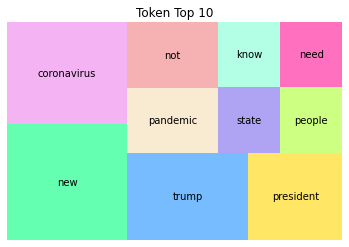

In [37]:
import squarify
import matplotlib.pyplot as plt

colors=['springgreen','violet','dodgerblue','gold','wheat','lightcoral',
        'mediumslateblue','greenyellow','aquamarine','deeppink']

wc_top5 = wc[wc['rank'] <= 10]
squarify.plot(sizes=wc_top5['percent'], label=wc_top5['word'], alpha=0.6, color=colors)
plt.axis('off')
plt.title('Token Top 10')
plt.show()

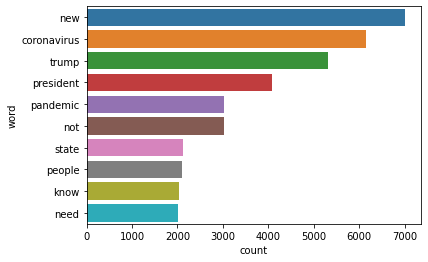

In [19]:
sns.barplot(x=wc['count'][:10],y=wc['word'][:10],orient='h')
plt.title('Token Top 10')
plt.show()

#### KNN + TfidVectorizer 

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words=st_words
                        ,tokenizer=tokenize
                        ,ngram_range = (1,2)
                        ,max_features = 5000
                        )
dtm = tfidf.fit_transform(df['sentence'])
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['d', 'm', 'nt', 's', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [21]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [22]:
result = nn.kneighbors([dtm.iloc[100]])
result

(array([[0.       , 1.       , 1.       , 1.       , 1.1726088]]),
 array([[  100,  5144, 10509, 35412,  7403]]))

In [23]:
df.iloc[result[1][0]]

,sentence,Tokens
100,A party that lost many of its working-class vo...,"[party, lose, workingclass, voter, month, elec..."
7717,What is this illustration saying? Maze,"[illustration, say, maze]"
17301,No. Should I Still Be Going Out?,[go]
58484,Dani Raymon bamboozles us. Puns and Anagrams,"[dani, raymon, bamboozle, pun, anagram]"
11810,Party leaders have a role to play now. Enough,"[party, leader, role, play]"
